In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/input')
import os

import numpy as np
import pandas as pd
from sklearn.externals import joblib
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from utils import plot_list, load_image, save_image, resize_image, get_cut_coordinates

METADATA_FILEPATH = '/input/metadata.csv'
IMG_DIR = '/output/auxiliary_data'
IMG_DIR_MASKS =os.path.join(IMG_DIR,'masks')
AUXILIARY_METADATA_FILEPATH = '/output/auxiliary_metadata.csv'

In [2]:
metadata = pd.read_csv(METADATA_FILEPATH)
metadata_train = metadata[metadata['is_train']==1]
metadata_train.head()

,file_path_image,file_path_mask,id,is_train,z
0,/public/challenges/kaggle-salt-identification/...,/public/challenges/kaggle-salt-identification/...,bd20d18369,1,513
1,/public/challenges/kaggle-salt-identification/...,/public/challenges/kaggle-salt-identification/...,bcae7b57ec,1,291
2,/public/challenges/kaggle-salt-identification/...,/public/challenges/kaggle-salt-identification/...,5aee63c515,1,611
3,/public/challenges/kaggle-salt-identification/...,/public/challenges/kaggle-salt-identification/...,e560423302,1,585
4,/public/challenges/kaggle-salt-identification/...,/public/challenges/kaggle-salt-identification/...,a21ae8cb6b,1,798


# Filter larger masks

In [3]:
sizes = []
for file_path in tqdm(metadata_train.file_path_mask):
    mask = load_image(file_path, is_mask=True)
    sizes.append(mask.sum())
    
metadata_train['size'] = sizes

metadata_large_masks = metadata_train[metadata_train['size'].between(300,8000)]
metadata_large_masks.head()

/usr/local/share/jupyter/kernels/neptune-kernel/neptunekernel.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # you may not use this file except in compliance with the License.


,file_path_image,file_path_mask,id,is_train,z,size
0,/public/challenges/kaggle-salt-identification/...,/public/challenges/kaggle-salt-identification/...,bd20d18369,1,513,2539
2,/public/challenges/kaggle-salt-identification/...,/public/challenges/kaggle-salt-identification/...,5aee63c515,1,611,1953
3,/public/challenges/kaggle-salt-identification/...,/public/challenges/kaggle-salt-identification/...,e560423302,1,585,3899
4,/public/challenges/kaggle-salt-identification/...,/public/challenges/kaggle-salt-identification/...,a21ae8cb6b,1,798,5127
5,/public/challenges/kaggle-salt-identification/...,/public/challenges/kaggle-salt-identification/...,eaefc56247,1,455,603


# Explore cut results

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


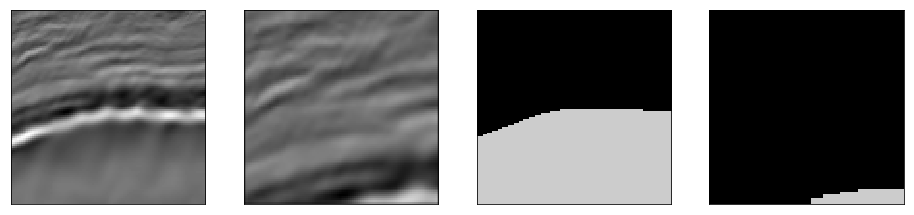

In [6]:
def present_cut(idx):
    row = metadata_large_masks.iloc[idx]
    image = load_image(row.file_path_image, is_mask=False)
    mask = load_image(row.file_path_mask, is_mask=True)
    (x1,x2),(y1,y2), was_cropped = get_cut_coordinates(mask,step=4, min_size=50, max_size=300)
    if was_cropped:
        synthetic_mask = resize_image(mask[x1:x2,y1:y2], (101,101),is_mask=True)
        synthetic_image = resize_image(image[x1:x2,y1:y2], (101,101))
        plot_list(images=[image, synthetic_image], labels=[mask, synthetic_mask])
        
present_cut(idx=18)

# Prepare synthetic data

In [7]:
!mkdir /output/auxiliary_data
!mkdir /output/auxiliary_data/masks /output/auxiliary_data/images

In [8]:
file_path_images,file_path_masks,ids, zs = [],[],[],[]
for _, row in tqdm(metadata_large_masks.iterrows()):
    image = load_image(row.file_path_image, is_mask=False)
    mask = load_image(row.file_path_mask, is_mask=True)
    (x1,x2),(y1,y2), was_cropped = get_cut_coordinates(mask,step=4, min_size=50, max_size=300)
    if was_cropped:
        synthetic_mask = resize_image(mask[x1:x2,y1:y2], (101,101),is_mask=True).astype(np.uint8)
        synthetic_image = (resize_image(image[x1:x2,y1:y2], (101,101))*255.).astype(np.uint8)
        idx = row.id
        
        file_path_image=os.path.join(IMG_DIR,'images','{}.png'.format(idx))
        file_path_mask=os.path.join(IMG_DIR,'masks','{}.png'.format(idx))
        save_image(synthetic_image, file_path_image)
        save_image(synthetic_mask, file_path_mask)
        test=load_image(file_path_mask)
    
        file_path_images.append(file_path_image)
        file_path_masks.append(file_path_mask)
        ids.append(idx)
        zs.append(row.z)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [9]:
metadata_small_masks = pd.DataFrame({'file_path_image':file_path_images,
                                     'file_path_mask':file_path_masks,
                                     'id':ids,
                                     'z':zs
                                    })
metadata_small_masks['is_train']=1

In [10]:
display(metadata_small_masks.shape)
metadata_small_masks.head()

(1488, 5)

,file_path_image,file_path_mask,id,z,is_train
0,/output/auxiliary_data/images/bd20d18369.png,/output/auxiliary_data/masks/bd20d18369.png,bd20d18369,513,1
1,/output/auxiliary_data/images/5aee63c515.png,/output/auxiliary_data/masks/5aee63c515.png,5aee63c515,611,1
2,/output/auxiliary_data/images/e560423302.png,/output/auxiliary_data/masks/e560423302.png,e560423302,585,1
3,/output/auxiliary_data/images/a21ae8cb6b.png,/output/auxiliary_data/masks/a21ae8cb6b.png,a21ae8cb6b,798,1
4,/output/auxiliary_data/images/eaefc56247.png,/output/auxiliary_data/masks/eaefc56247.png,eaefc56247,455,1


In [11]:
metadata_small_masks.to_csv(AUXILIARY_METADATA_FILEPATH)

# How to download auxiliary data

- Click on `Files` tab on the left  

- Click on `SAL` and `uploads`

- Download `auxiliary_data.zip`

- Train new model with auxiliary data!